In [ ]:
#import dependencies

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import os, torch, timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment

from tqdm import tqdm
import wandb 
import json
from datetime import datetime
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy

/Users/SJ/Documents/lmage-based-breed-recognition-for-cattle-and-buffaloes-of-India/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#configuration values for the model training setup.

CONFIG = {
    'data_dir': "/Users/SJ/Documents/lmage-based-breed-recognition-for-cattle-and-buffaloes-of-India/data/Indian_bovine_breeds",
    'batch_size': 32,
    'img_size': 224,
    'epochs_warmup': 5,
    'epochs_finetune': 20,
    'lr_warmup': 3e-4,
    'lr_finetune': 1e-5,
    'patience': 7,
    'weight_decay': 1e-3,
    'model_name': 'convnext_tiny',
    'drop_path_rate': 0.2,
    'test_size': 0.2,
    'random_state': 42,
    'mixup_alpha': 0.2,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"Configuration: {json.dumps(CONFIG, indent=2)}")

Using device: cuda
Configuration: {
  "data_dir": "/kaggle/input/indian-bovine-breeds/Indian_bovine_breeds",
  "batch_size": 32,
  "img_size": 224,
  "epochs_warmup": 5,
  "epochs_finetune": 20,
  "lr_warmup": 0.0003,
  "lr_finetune": 1e-05,
  "patience": 7,
  "weight_decay": 0.001,
  "model_name": "convnext_tiny",
  "drop_path_rate": 0.2,
  "test_size": 0.2,
  "random_state": 42,
  "mixup_alpha": 0.2,
  "cutmix_alpha": 1.0,
  "label_smoothing": 0.1
}


In [3]:
def get_transforms(img_size=224, is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

print("Transforms defined")

Transforms defined


In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(CONFIG['data_dir'], transform=get_transforms(CONFIG['img_size'], True))
val_dataset = datasets.ImageFolder(CONFIG['data_dir'], transform=get_transforms(CONFIG['img_size'], False))

# Stratified split
train_idx, val_idx = train_test_split(
    list(range(len(train_dataset.targets))),
    test_size=CONFIG['test_size'],
    stratify=train_dataset.targets,
    random_state=CONFIG['random_state']
)

train_ds = Subset(train_dataset, train_idx)
val_ds = Subset(val_dataset, val_idx)

# Calculate class weights for imbalanced datasets
targets = np.array(train_dataset.targets)
class_counts = np.bincount(targets)
class_weights = 1.0 / (class_counts + 1e-6)  
sample_weights = [class_weights[t] for t in targets[train_idx]]

# Create weighted sampler
sampler = WeightedRandomSampler(
    sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

# Create dataloaders
train_loader = DataLoader(
    train_ds, 
    batch_size=CONFIG['batch_size'], 
    sampler=sampler,
    num_workers=2,  
    pin_memory=True,
    drop_last=True  
)

val_loader = DataLoader(
    val_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=2,  
    pin_memory=True
)

classes = train_dataset.classes
num_classes = len(classes)

print(f"Dataset info:")
print(f"- Classes: {classes}")
print(f"- Class distribution: {dict(zip(classes, class_counts))}")
print(f"- Training samples: {len(train_ds)}")
print(f"- Validation samples: {len(val_ds)}")
print("Data loaders created")

Dataset info:
- Classes: ['Alambadi', 'Amritmahal', 'Ayrshire', 'Banni', 'Bargur', 'Bhadawari', 'Brown_Swiss', 'Dangi', 'Deoni', 'Gir', 'Guernsey', 'Hallikar', 'Hariana', 'Holstein_Friesian', 'Jaffrabadi', 'Jersey', 'Kangayam', 'Kankrej', 'Kasargod', 'Kenkatha', 'Kherigarh', 'Khillari', 'Krishna_Valley', 'Malnad_gidda', 'Mehsana', 'Murrah', 'Nagori', 'Nagpuri', 'Nili_Ravi', 'Nimari', 'Ongole', 'Pulikulam', 'Rathi', 'Red_Dane', 'Red_Sindhi', 'Sahiwal', 'Surti', 'Tharparkar', 'Toda', 'Umblachery', 'Vechur']
- Class distribution: {'Alambadi': 99, 'Amritmahal': 94, 'Ayrshire': 234, 'Banni': 108, 'Bargur': 93, 'Bhadawari': 86, 'Brown_Swiss': 225, 'Dangi': 82, 'Deoni': 99, 'Gir': 372, 'Guernsey': 119, 'Hallikar': 186, 'Hariana': 129, 'Holstein_Friesian': 328, 'Jaffrabadi': 101, 'Jersey': 203, 'Kangayam': 91, 'Kankrej': 178, 'Kasargod': 95, 'Kenkatha': 55, 'Kherigarh': 36, 'Khillari': 113, 'Krishna_Valley': 136, 'Malnad_gidda': 107, 'Mehsana': 94, 'Murrah': 173, 'Nagori': 89, 'Nagpuri': 182, 

In [ ]:
def create_model(model_name, num_classes, drop_path_rate=0.2, pretrained=True):
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes,
        drop_path_rate=drop_path_rate
    )
    return model.to(DEVICE)

# Create model
model = create_model(CONFIG['model_name'], num_classes, CONFIG['drop_path_rate'])
print(f"Model created: {CONFIG['model_name']}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


#Training Functions

def train_one_epoch(model, loader, optimizer, mixup_fn, criterion, scaler, use_mixup=True):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for batch_idx, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        
        if use_mixup and imgs.size(0) % 2 != 0:
            continue
            
        optimizer.zero_grad()
        
        if use_mixup:
            imgs, labels_mixed = mixup_fn(imgs, labels)
         
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(imgs)
            if use_mixup:
                loss = criterion(outputs, labels_mixed)
            else:
                loss = nn.CrossEntropyLoss()(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * imgs.size(0)
        if not use_mixup:
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = running_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    accuracy = correct / total if total > 0 else 0.0
    
    return avg_loss, accuracy

def validate(model, loader, criterion=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            
            with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': loss.item()})
    
    avg_loss = running_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

print("Training functions defined")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Model created: convnext_tiny
Total parameters: 27,851,657
Training functions defined


In [6]:
# Setup mixup and loss
mixup_fn = Mixup(
    mixup_alpha=CONFIG['mixup_alpha'],
    cutmix_alpha=CONFIG['cutmix_alpha'],
    label_smoothing=CONFIG['label_smoothing'],
    num_classes=num_classes
)
criterion = SoftTargetCrossEntropy()
scaler = torch.cuda.amp.GradScaler()

# Training history
history = {
    'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []
}

best_acc = 0.0
patience_counter = 0

print("Training setup complete")

Training setup complete


/tmp/ipykernel_19/3981459420.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [7]:
print("Phase 1: Training classifier only")

# Freeze backbone
for name, param in model.named_parameters():
    if 'head' not in name and 'classifier' not in name:
        param.requires_grad = False

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['lr_warmup'],
    weight_decay=CONFIG['weight_decay']
)

for epoch in range(CONFIG['epochs_warmup']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs_warmup']}")
    
    train_loss, _ = train_one_epoch(model, train_loader, optimizer, mixup_fn, criterion, scaler)
    val_loss, val_acc, _, _ = validate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model_warmup.pth')
        print(f"Saved best model (acc: {best_acc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1

print("Phase 1 completed")

Phase 1: Training classifier only

Epoch 1/5


Training:   9%|▉         | 14/148 [00:09<01:21,  1.65it/s, loss=4.03]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  14%|█▍        | 21/148 [00:15<01:30,  1.41it/s, loss=3.79]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.5360 | Val Loss: 2.7985 | Val Acc: 0.2909
Saved best model (acc: 0.2909)

Epoch 2/5


Training:   7%|▋         | 11/148 [00:05<01:02,  2.19it/s, loss=3.41]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  20%|█▉        | 29/148 [00:18<01:20,  1.48it/s, loss=3.12]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.0938 | Val Loss: 2.4501 | Val Acc: 0.3769
Saved best model (acc: 0.3769)

Epoch 3/5


Training:  45%|████▍     | 66/148 [00:34<00:38,  2.11it/s, loss=3.07]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  73%|███████▎  | 108/148 [00:55<00:18,  2.18it/s, loss=3.13]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.9169 | Val Loss: 2.2658 | Val Acc: 0.4241
Saved best model (acc: 0.4241)

Epoch 4/5


Training:  20%|█▉        | 29/148 [00:14<01:02,  1.90it/s, loss=3.26]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  78%|███████▊  | 115/148 [00:56<00:18,  1.82it/s, loss=2.47]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8474 | Val Loss: 2.1518 | Val Acc: 0.4292
Saved best model (acc: 0.4292)

Epoch 5/5


Training:  59%|█████▉    | 88/148 [00:43<00:25,  2.34it/s, loss=2.92]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  91%|█████████ | 134/148 [01:06<00:07,  1.88it/s, loss=3.04]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.8003 | Val Loss: 2.0379 | Val Acc: 0.4755
Saved best model (acc: 0.4755)
Phase 1 completed


In [8]:
print("Phase 2: Fine-tuning all layers")

# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['lr_finetune'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2, eta_min=1e-7
)

for epoch in range(CONFIG['epochs_finetune']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs_finetune']}")
    
    train_loss, _ = train_one_epoch(model, train_loader, optimizer, mixup_fn, criterion, scaler)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + CONFIG['epochs_warmup'],
            'best_acc': best_acc,
            'config': CONFIG,
            'classes': classes
        }, 'best_model_final.pth')
        print(f"Saved best model (acc: {best_acc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print("⏹️ Early stopping triggered")
        break

print("Phase 2 completed")

Phase 2: Fine-tuning all layers

Epoch 1/20


Training:  20%|█▉        | 29/148 [00:15<00:50,  2.37it/s, loss=3.17]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.6499 | Val Loss: 1.6606 | Val Acc: 0.5295 | LR: 9.05e-06
Saved best model (acc: 0.5295)

Epoch 2/20


Training:   5%|▌         | 8/148 [00:04<01:19,  1.77it/s, loss=2.28]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   9%|▉         | 14/148 [00:07<01:06,  2.01it/s, loss=2.97]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.4605 | Val Loss: 1.5053 | Val Acc: 0.5742 | LR: 6.58e-06
Saved best model (acc: 0.5742)

Epoch 3/20


Training:  22%|██▏       | 32/148 [00:16<00:44,  2.59it/s, loss=3.01]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.5011 | Val Loss: 1.4744 | Val Acc: 0.5742 | LR: 3.52e-06

Epoch 4/20


Training:  14%|█▎        | 20/148 [00:11<00:51,  2.50it/s, loss=1.71]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  24%|██▍       | 36/148 [00:19<00:52,  2.13it/s, loss=2.86]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.3534 | Val Loss: 1.4139 | Val Acc: 0.5894 | LR: 1.05e-06
Saved best model (acc: 0.5894)

Epoch 5/20


Training:  98%|█████████▊| 145/148 [01:11<00:01,  2.33it/s, loss=2.73]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.4091 | Val Loss: 1.4117 | Val Acc: 0.5970 | LR: 1.00e-05
Saved best model (acc: 0.5970)

Epoch 6/20


Training:   0%|          | 0/148 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  36%|███▌      | 53/148 [00:26<00:40,  2.35it/s, loss=2.98]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.3939 | Val Loss: 1.4088 | Val Acc: 0.5902 | LR: 9.76e-06

Epoch 7/20


Training:  11%|█▏        | 17/148 [00:08<01:00,  2.15it/s, loss=1.85]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.2483 | Val Loss: 1.3414 | Val Acc: 0.6147 | LR: 9.05e-06
Saved best model (acc: 0.6147)

Epoch 8/20


Training:  22%|██▏       | 32/148 [00:15<00:41,  2.78it/s, loss=2.63]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.2285 | Val Loss: 1.3125 | Val Acc: 0.6206 | LR: 7.96e-06
Saved best model (acc: 0.6206)

Epoch 9/20


Training:   0%|          | 0/148 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  15%|█▍        | 22/148 [00:11<01:01,  2.06it/s, loss=1.64]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.2860 | Val Loss: 1.3252 | Val Acc: 0.6197 | LR: 6.58e-06

Epoch 10/20


Training:   5%|▌         | 8/148 [00:04<01:06,  2.11it/s, loss=2.11]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  11%|█         | 16/148 [00:09<01:00,  2.19it/s, loss=2.21]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1860 | Val Loss: 1.2953 | Val Acc: 0.6332 | LR: 5.05e-06
Saved best model (acc: 0.6332)

Epoch 11/20


Training:  17%|█▋        | 25/148 [00:13<00:50,  2.44it/s, loss=1.76]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  61%|██████    | 90/148 [00:46<00:31,  1.85it/s, loss=2.57]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1245 | Val Loss: 1.2704 | Val Acc: 0.6417 | LR: 3.52e-06
Saved best model (acc: 0.6417)

Epoch 12/20


Training:  99%|█████████▊| 146/148 [01:13<00:00,  2.27it/s, loss=2.28]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1636 | Val Loss: 1.2530 | Val Acc: 0.6391 | LR: 2.14e-06

Epoch 13/20


Training:   0%|          | 0/148 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  19%|█▉        | 28/148 [00:15<01:28,  1.36it/s, loss=2.42]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1627 | Val Loss: 1.2448 | Val Acc: 0.6425 | LR: 1.05e-06
Saved best model (acc: 0.6425)

Epoch 14/20


Training:  18%|█▊        | 27/148 [00:14<01:34,  1.29it/s, loss=2.76]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1616 | Val Loss: 1.2419 | Val Acc: 0.6442 | LR: 3.42e-07
Saved best model (acc: 0.6442)

Epoch 15/20


Train Loss: 2.0707 | Val Loss: 1.2410 | Val Acc: 0.6467 | LR: 1.00e-05
Saved best model (acc: 0.6467)

Epoch 16/20


Training:  53%|█████▎    | 79/148 [00:39<00:26,  2.64it/s, loss=2.23]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.1404 | Val Loss: 1.2426 | Val Acc: 0.6341 | LR: 9.94e-06

Epoch 17/20


Training:   7%|▋         | 11/148 [00:06<01:15,  1.80it/s, loss=2.37]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0749 | Val Loss: 1.2690 | Val Acc: 0.6391 | LR: 9.76e-06

Epoch 18/20


Train Loss: 2.0796 | Val Loss: 1.2361 | Val Acc: 0.6366 | LR: 9.46e-06

Epoch 19/20


Training:   6%|▌         | 9/148 [00:04<00:59,  2.35it/s, loss=2.28]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  53%|█████▎    | 79/148 [00:38<00:26,  2.61it/s, loss=2.53]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0042 | Val Loss: 1.2392 | Val Acc: 0.6408 | LR: 9.05e-06

Epoch 20/20


Training:  37%|███▋      | 55/148 [00:27<00:37,  2.48it/s, loss=2.3]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 2.0062 | Val Loss: 1.2406 | Val Acc: 0.6492 | LR: 8.55e-06
Saved best model (acc: 0.6492)
Phase 2 completed


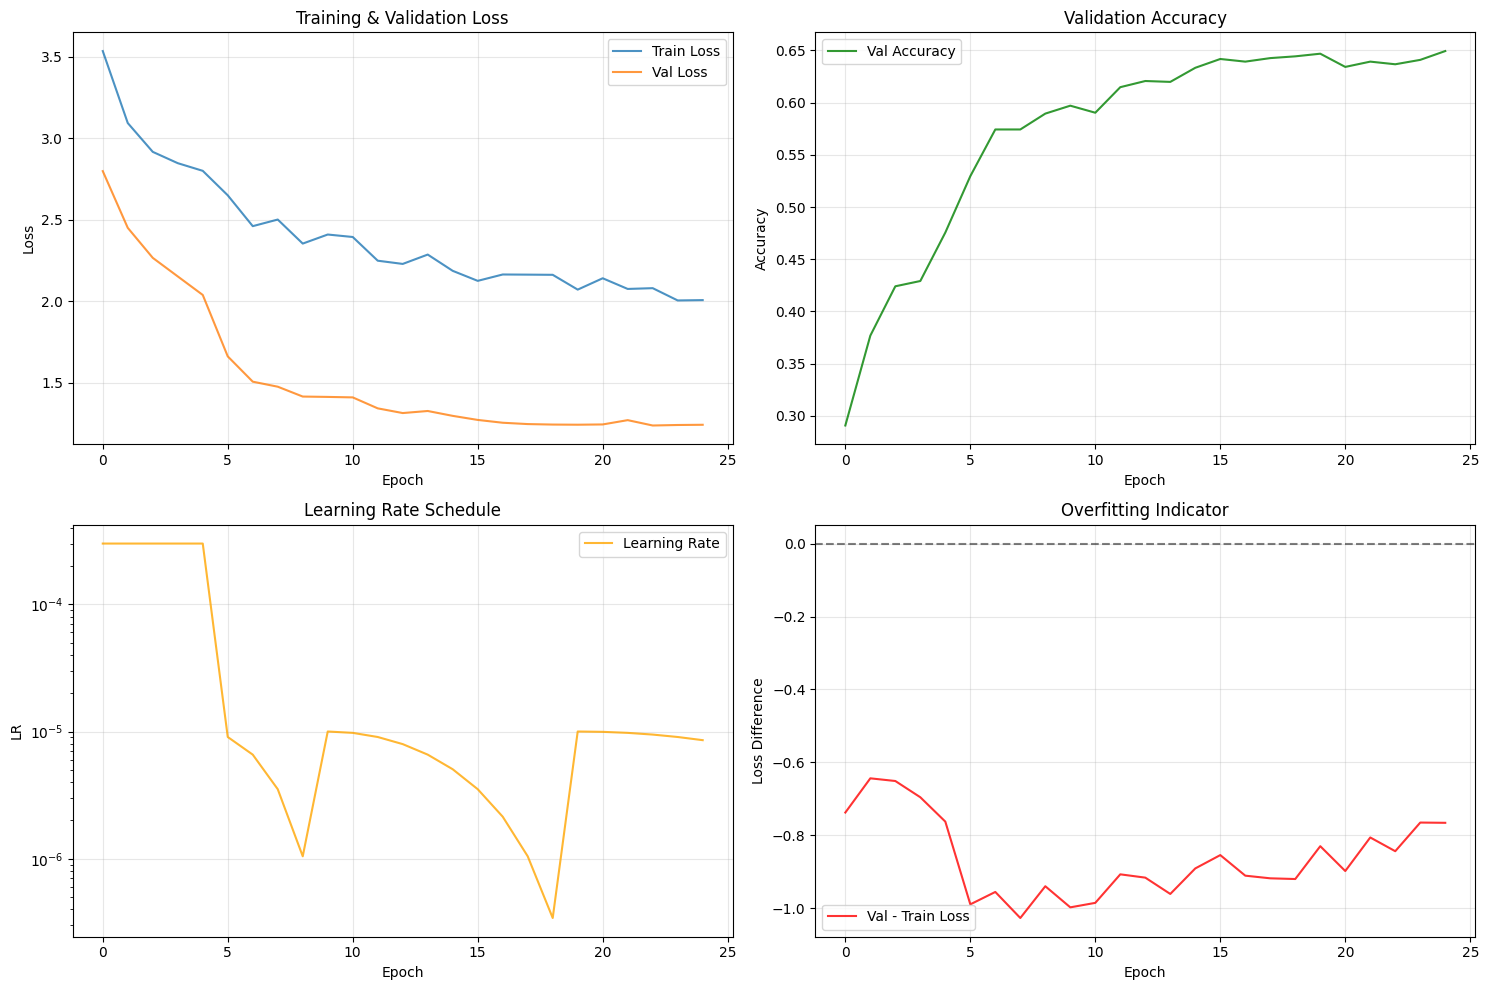

In [ ]:
def plot_training_history(history):
    """Enhanced training history visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', alpha=0.8)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', alpha=0.8)
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curve
    axes[0, 1].plot(history['val_acc'], label='Val Accuracy', color='green', alpha=0.8)
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate schedule
    axes[1, 0].plot(history['lr'], label='Learning Rate', color='orange', alpha=0.8)
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('LR')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss difference (overfitting indicator)
    loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(loss_diff, label='Val - Train Loss', color='red', alpha=0.8)
    axes[1, 1].set_title('Overfitting Indicator')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


🎉 Training Completed!
Final Results:
   - Best Validation Accuracy: 0.6492
   - Final Validation Accuracy: 0.6492
   - Final Validation Loss: 1.2406
Classification Report:
                   precision    recall  f1-score   support

         Alambadi       0.89      0.80      0.84        20
       Amritmahal       0.58      0.58      0.58        19
         Ayrshire       0.77      0.70      0.73        47
            Banni       0.45      0.41      0.43        22
           Bargur       0.70      0.84      0.76        19
        Bhadawari       0.40      0.35      0.38        17
      Brown_Swiss       0.92      0.78      0.84        45
            Dangi       0.75      0.75      0.75        16
            Deoni       0.94      0.75      0.83        20
              Gir       0.72      0.78      0.75        74
         Guernsey       0.48      0.88      0.62        24
         Hallikar       0.77      0.81      0.79        37
          Hariana       0.59      0.38      0.47        26


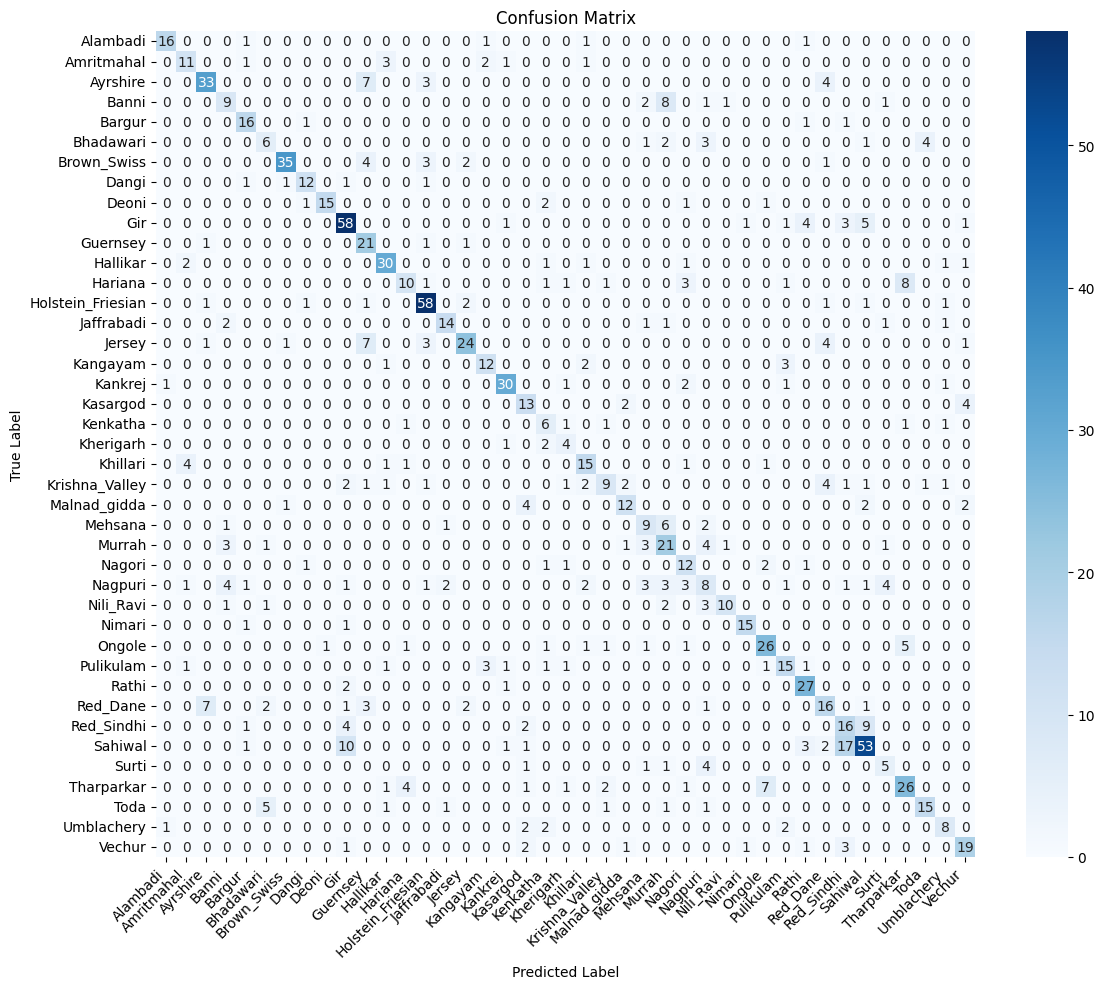

In [10]:
def analyze_results(val_preds, val_labels, classes):
    """Comprehensive results analysis"""
    # Classification report
    print("Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=classes))
    
    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return classification_report(val_labels, val_preds, target_names=classes, output_dict=True)

# Final evaluation on validation set
model.eval()
final_val_loss, final_val_acc, final_preds, final_labels = validate(model, val_loader)

print(f"\n🎉 Training Completed!")
print(f"Final Results:")
print(f"   - Best Validation Accuracy: {max(history['val_acc']):.4f}")
print(f"   - Final Validation Accuracy: {final_val_acc:.4f}")
print(f"   - Final Validation Loss: {final_val_loss:.4f}")

# Analyze results
report = analyze_results(final_preds, final_labels, classes)

In [11]:
print(f"\nTraining Summary:")
print(f"   - Model: {CONFIG['model_name']}")
print(f"   - Total Epochs: {len(history['val_acc'])}")
print(f"   - Best Accuracy: {max(history['val_acc']):.4f}")
print(f"   - Number of Classes: {num_classes}")
print(f"   - Dataset Size: {len(train_ds)} train, {len(val_ds)} val")

# Save final results
results = {
    'config': CONFIG,
    'history': history,
    'final_accuracy': final_val_acc,
    'best_accuracy': max(history['val_acc']),
    'classes': classes,
    'classification_report': report
}

with open('training_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)

print("Results saved to 'training_results.json'")
print("Best model saved to 'best_model_final.pth'")


Training Summary:
   - Model: convnext_tiny
   - Total Epochs: 25
   - Best Accuracy: 0.6492
   - Number of Classes: 41
   - Dataset Size: 4741 train, 1186 val
Results saved to 'training_results.json'
Best model saved to 'best_model_final.pth'
